In [1]:
import cmdstanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
from hashlib import md5
import json
import arviz as az
import sys
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer

In [91]:
y_data = pd.read_csv(os.path.realpath("data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("data/x_age.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("data/ship_index.csv"), usecols=["ship"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("data/engine_index.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
shipsize_data = pd.DataFrame({"shipsize": np.zeros(y_data.shape[0], dtype=np.int32)})
ship_size_mapping_data = pd.read_csv(os.path.realpath("data/shipsize_index.csv"), usecols=["shipsize"])
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]
    shipsize_data.at[x, "shipsize"] = ship_size_mapping_data.at[ship_data.at[x, "ship"]-1, "shipsize"]


In [92]:
engine_count = int(np.max(engine_data["engine"]))
ship_count = int(np.max(ship_data["ship"]))
max_age = int(np.max(age_data["age"]))
data_count = y_data.shape[0]
shipsize_count = int(np.max(shipsize_data["shipsize"]))
print(engine_count, shipsize_count, ship_count, max_age, data_count)
print(engine_data.shape, shipsize_data.shape, ship_data.shape, age_data.shape, y_data.shape)

5 5 99 31 653
(653, 1) (653, 1) (653, 1) (653, 1) (653, 1)


# gaussian process model

In [4]:
#gp_model_dir = "gaussianprocess/models/hier_gp_weak/hier_gp_weak.stan"
gp_model_dir = "gaussianprocess/models/trend_hp_engineVar/trend_hp_engineVar.stan"
gp_model = CmdStanModel(stan_file=gp_model_dir) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/gaussianprocess/models/trend_hp_engineVar/trend_hp_engineVar


In [5]:
data = {
    "N": int(data_count),
    "N_engines": int(engine_count),
    "N_ships": int(ship_count),
    "N_ages_obs": int(max_age),
    "N_ages": int(max_age),
    "ship_engine_ind": ship_engine_mapping_data["engine"].values.tolist(),
    "ship_ind": ship_data["ship"].values.tolist(),
    "age_ind": age_data["age"].values.tolist(),
    "y": y_data["y"].values.tolist(),
}

In [6]:
%%time
gp_model_fit = gp_model.sample(chains=4, cores=4, data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


CPU times: user 1.22 s, sys: 105 ms, total: 1.33 s
Wall time: 2min 15s


In [7]:
gp_model_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmplwvp13kq/trend_hp_engineVar-202008241810-1-5zlrk4tn.csv, /tmp/tmplwvp13kq/trend_hp_engineVar-202008241810-2-jop7trnb.csv, /tmp/tmplwvp13kq/trend_hp_engineVar-202008241810-3-2hh43wdl.csv, /tmp/tmplwvp13kq/trend_hp_engineVar-202008241810-4-9fksyieu.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /tmp/tmplwvp13kq/trend_hp_engineVar-202008241810-1-5zlrk4tn.csv, /tmp/tmplwvp13kq/trend_hp_engineVar-202008241810-2-jop7trnb.csv, /tmp/tmplwvp13kq/trend_hp_engineVar-202008241810-3-2hh43wdl.csv, /tmp/tmplwvp13kq/trend_hp_engineVar-202008241810-4-9fksyieu.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [8]:
gp_az_inference = az.from_cmdstanpy(gp_model_fit, posterior_predictive="obs_mu", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

# spline model

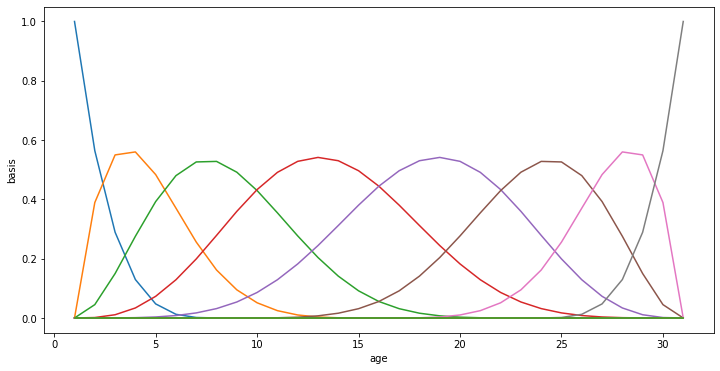

In [9]:
degree = 4
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [10]:
basis_df.shape

(31, 13)

In [11]:
spline_model_file = os.path.join('spline/models','layer3_nc_diffsd_parammubar.stan')
layer3_model = CmdStanModel(stan_file=spline_model_file) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/models/layer3_nc_diffsd_parammubar


In [12]:
data = {
    "K" : basis_df.shape[1],
    "N" : int(data_count),  # number of total values
    "T" : int(max_age),  # length of time of data(31)
    "S" : int(ship_count), #failure_df.shape[1],  # number of ships(99)
    "E" : int(engine_count),  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": int(data_count),
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [13]:
%%time
spline_model_fit = layer3_model.sample(chains=4, cores=4, data=data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


CPU times: user 594 ms, sys: 46.3 ms, total: 640 ms
Wall time: 2min 39s


In [14]:
spline_model_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmplwvp13kq/layer3_nc_diffsd_parammubar-202008241813-1-h5cyqq05.csv, /tmp/tmplwvp13kq/layer3_nc_diffsd_parammubar-202008241813-2-k23lsc2b.csv, /tmp/tmplwvp13kq/layer3_nc_diffsd_parammubar-202008241813-3-bojneq5m.csv, /tmp/tmplwvp13kq/layer3_nc_diffsd_parammubar-202008241813-4-oc4p7mp_.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
5 of 4000 (0.12%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


"Processing csv files: /tmp/tmplwvp13kq/layer3_nc_diffsd_parammubar-202008241813-1-h5cyqq05.csv, /tmp/tmplwvp13kq/layer3_nc_diffsd_parammubar-202008241813-2-k23lsc2b.csv, /tmp/tmplwvp13kq/layer3_nc_diffsd_parammubar-202008241813-3-bojneq5m.csv, /tmp/tmplwvp13kq/layer3_nc_diffsd_parammubar-202008241813-4-oc4p7mp_.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n5 of 4000 (0.12%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete."

In [15]:
#pd.set_option('display.max_rows', None)
spline_model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-413.674000,0.518633,17.700100,-443.536000,-413.374000,-385.324000,1164.75,3.19705,1.003000
mu_a_bar,-0.049193,0.010646,0.843729,-1.437330,-0.050033,1.332390,6280.54,17.23910,0.999556
mu_w_bar[1],-1.118640,0.008076,0.490166,-1.921460,-1.120390,-0.304934,3683.89,10.11170,0.999959
mu_w_bar[2],0.829424,0.008207,0.512076,-0.018838,0.833652,1.663480,3893.58,10.68730,0.999856
mu_w_bar[3],0.342376,0.009698,0.610347,-0.687789,0.344908,1.334470,3960.59,10.87120,0.999993
...,...,...,...,...,...,...,...,...,...
y_new_pred[649],2.202950,0.013007,0.823407,0.846326,2.208590,3.538340,4007.64,11.00040,0.999705
y_new_pred[650],0.511040,0.013549,0.867199,-0.911431,0.500432,1.958100,4096.54,11.24440,0.999602
y_new_pred[651],0.716626,0.013616,0.862275,-0.710350,0.695488,2.143840,4010.38,11.00790,1.001530


In [16]:
spline_az_inference = az.from_cmdstanpy(spline_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

# check out arviz stuff

In [17]:
gp_az_inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [18]:
spline_az_inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [20]:
az.loo(gp_az_inference, pointwise=True)

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 653 log-likelihood matrix

         Estimate       SE
elpd_loo  -742.53    18.49
p_loo      217.14        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      440   67.4%
 (0.5, 0.7]   (ok)        173   26.5%
   (0.7, 1]   (bad)        38    5.8%
   (1, Inf)   (very bad)    2    0.3%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [21]:
az.loo(spline_az_inference, pointwise=True)

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 653 log-likelihood matrix

         Estimate       SE
elpd_loo  -802.09    18.83
p_loo       95.11        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      631   96.6%
 (0.5, 0.7]   (ok)         16    2.5%
   (0.7, 1]   (bad)         6    0.9%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [75]:
import logging
logger=  logging.getLogger()
logger.setLevel(logging.DEBUG)
comp = az.compare({"gaussian_process": gp_az_inference, "spline": spline_az_inference}, ic="loo")
comp

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
gaussian_process,0,-742.529,217.14,0,1,18.2851,0,True,log
spline,1,-802.093,95.1064,59.5636,2.51766e-09,18.7379,11.9617,True,log


In [76]:
spline_yhat = np.mean(spline_model_fit.get_drawset(params=["y_new_pred"]), axis=0).values

In [77]:
gp_yhat = np.mean(gp_model_fit.get_drawset(params=["obs_mu"]), axis=0).values

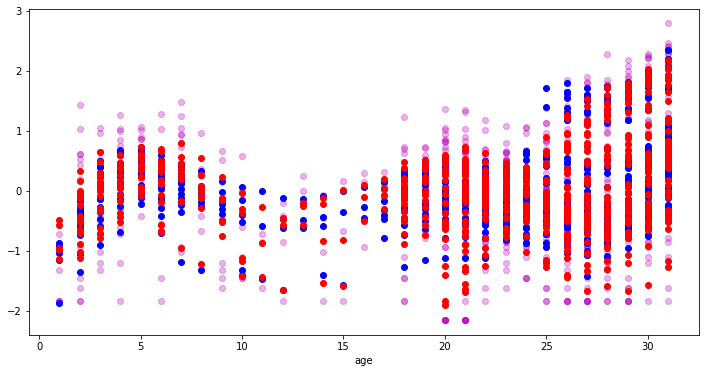

In [78]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
ax.scatter(age_data, spline_yhat, color="blue", linewidth=1)
ax.scatter(age_data, gp_yhat, color="r", linewidth=1)

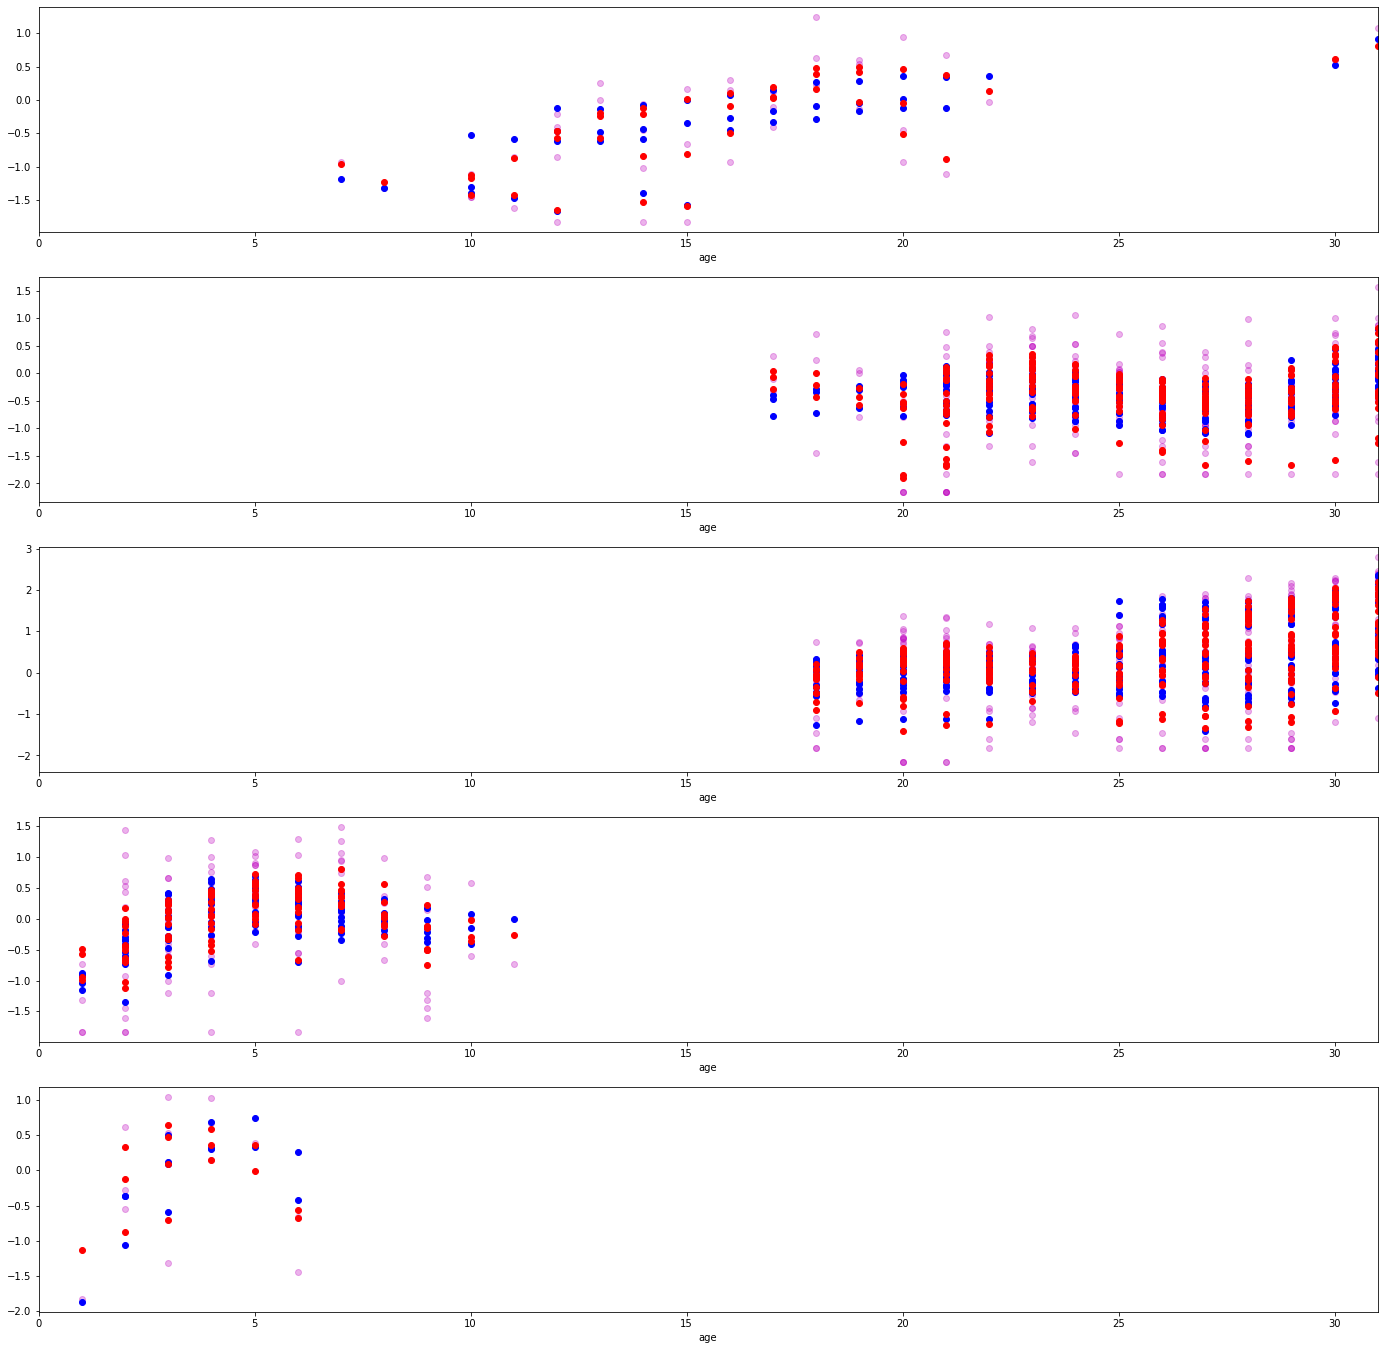

In [79]:
fig, ax = plt.subplots(engine_count,1, figsize=(24, 24))

for x in range(1, engine_count+1):
    ax[x-1].set_xlabel('age')
    ax[x-1].set_xlim(0, 31) 
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], y_data["y"].values[engine_data["engine"].values == x], color='m', alpha=0.3)
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], spline_yhat[engine_data["engine"].values == x], color="blue")
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], gp_yhat[engine_data["engine"].values == x], color="r")

In [80]:
mean_squared_error(spline_yhat, y_data["y"].values)

0.48715432288030364

In [81]:
mean_squared_error(gp_yhat, y_data["y"].values)

0.2571485640733965

# stack em up

In [82]:
stacked_yhat = np.dot(np.transpose(np.vstack([gp_yhat, spline_yhat])), comp.weight.values)

In [83]:
mean_squared_error(stacked_yhat, y_data["y"].values)

0.2571485643715839

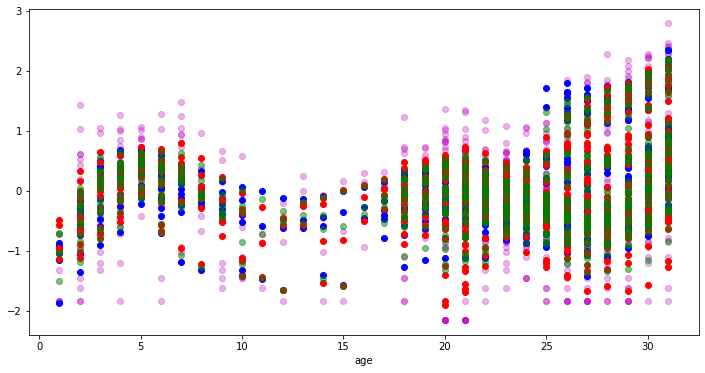

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
ax.scatter(age_data, spline_yhat, color="blue", linewidth=1)
ax.scatter(age_data, gp_yhat, color="r", linewidth=1)
ax.scatter(age_data, stacked_yhat, color="green", linewidth=1, alpha=0.5)

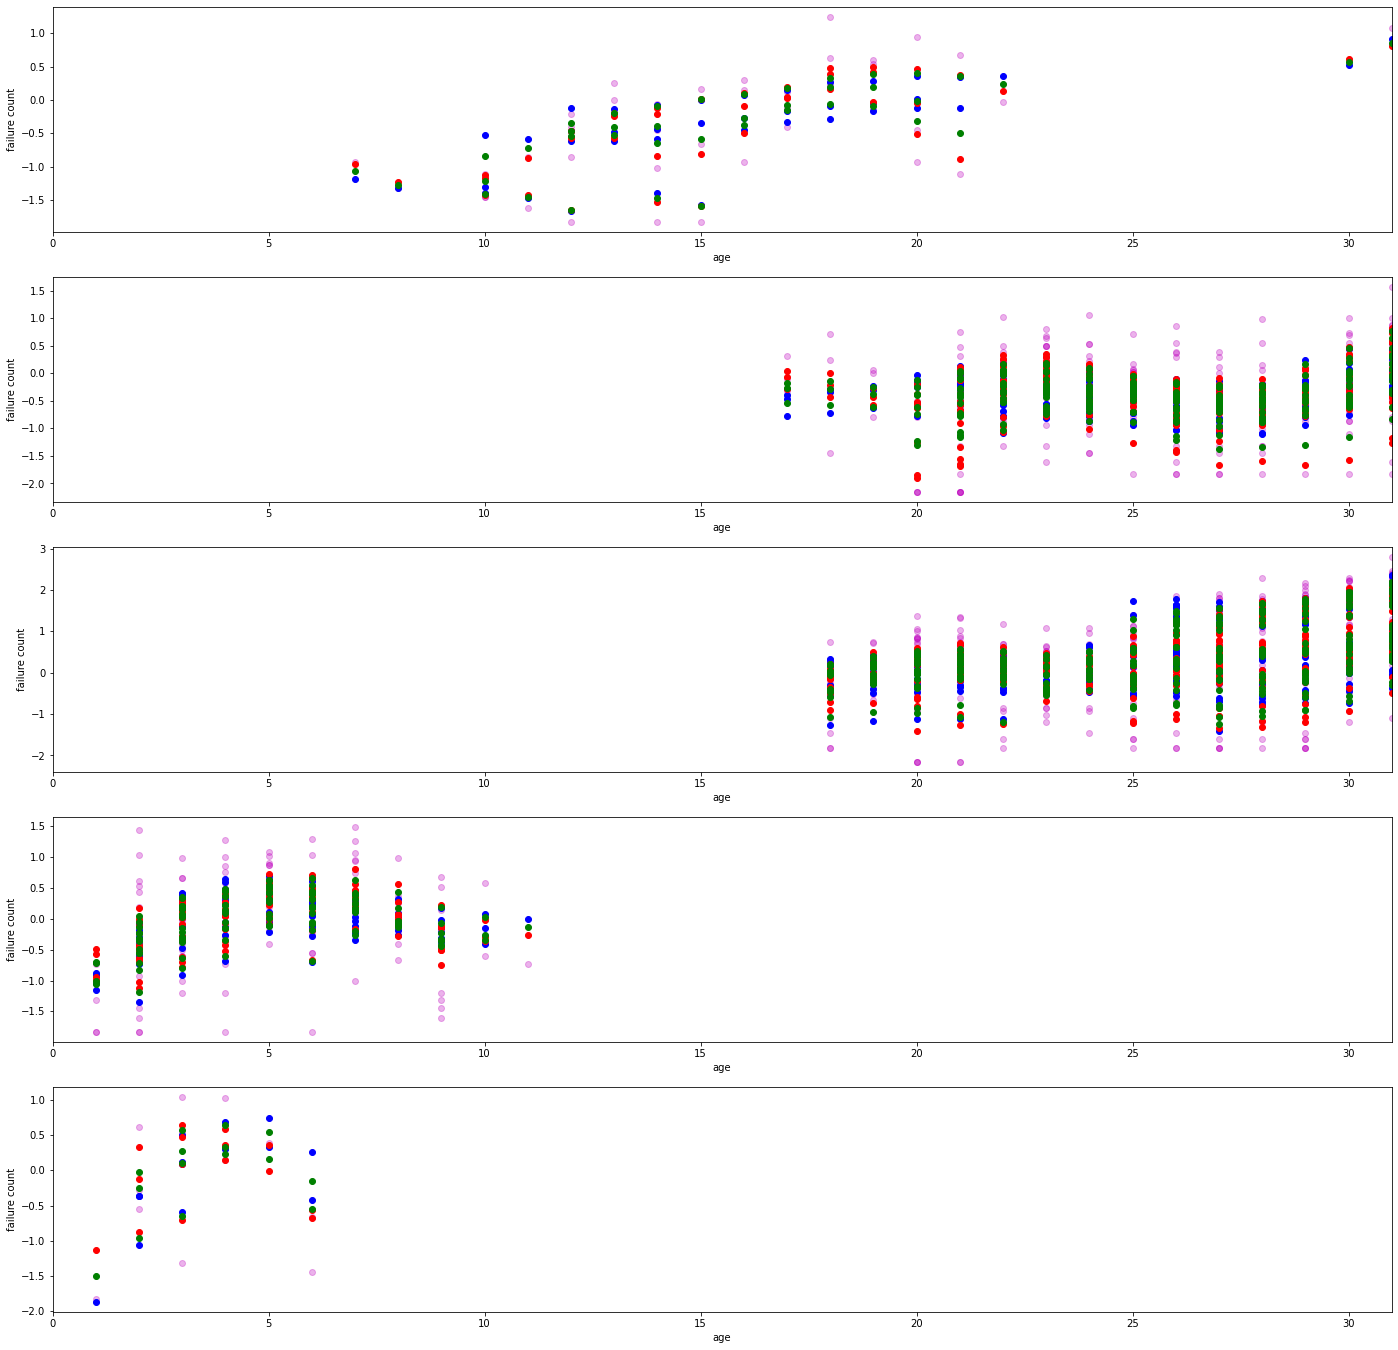

In [65]:
fig, ax = plt.subplots(engine_count,1, figsize=(24, 24))

for x in range(1, engine_count+1):
    ax[x-1].set_xlabel('age')
    ax[x-1].set_ylabel('failure count')
    ax[x-1].set_xlim(0, 31) 
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], y_data["y"].values[engine_data["engine"].values == x], color='m', alpha=0.3)
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], spline_yhat[engine_data["engine"].values == x], color="blue")
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], gp_yhat[engine_data["engine"].values == x], color="r")
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], stacked_yhat[engine_data["engine"].values == x], color="green")

# compare gp models

In [66]:
gp_model_old_dir = "gaussianprocess/models/hier_gp_weak/hier_gp_weak.stan"
old_gp_model = CmdStanModel(stan_file=gp_model_dir) #compile_model(layer3_path)
data = {
    "N": int(data_count),
    "N_engines": int(engine_count),
    "N_ships": int(ship_count),
    "N_ages_obs": int(max_age),
    "N_ages": int(max_age),
    "ship_engine_ind": ship_engine_mapping_data["engine"].values.tolist(),
    "ship_ind": ship_data["ship"].values.tolist(),
    "age_ind": age_data["age"].values.tolist(),
    "y": y_data["y"].values.tolist(),
}
old_gp_model_fit = gp_model.sample(chains=4, cores=4, data=data)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/gaussianprocess/models/trend_hp_engineVar/trend_hp_engineVar
DEBUG:cmdstanpy:input tempfile: /tmp/tmplwvp13kq/6auncmtg.json
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
DEBUG:cmdstanpy:sampling: ['/home/dashadower/git_repos/aria/regression/failure_bma/gaussianprocess/models/trend_hp_engineVar/trend_hp_engineVar', 'id=1', 'random', 'seed=67179', 'data', 'file=/tmp/tmplwvp13kq/6auncmtg.json', 'output', 'file=/tmp/tmplwvp13kq/trend_hp_engineVar-202008241840-1-61r7mx2q.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:sampling: ['/home/dashadower/git_repos/aria/regression/failure_bma/gaussianprocess/models/trend_hp_engineVar/trend_hp_engineVar', 'id=2', 'random', 'seed=67179', 'data', 'file=/tmp/tmplwvp13kq/6auncmtg.json', 'output', 'file=/tmp/tmplwvp

In [72]:
old_gp_yhat = np.mean(old_gp_model_fit.get_drawset(params=["obs_mu"]), axis=0).values

In [69]:
old_gp_az_inference = az.from_cmdstanpy(old_gp_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

In [70]:
gp_comp = az.compare({"trend_hp_engineVar": gp_az_inference, "hier_gp_weak": old_gp_az_inference}, ic="loo")

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats

In [71]:
gp_comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
trend_hp_engineVar,0,-742.529,217.14,0,0.713239,18.2005,0,True,log
hier_gp_weak,1,-743.657,215.723,1.12803,0.286761,18.2733,1.17654,True,log


In [73]:
gp_stacked_yhat = np.dot(np.transpose(np.vstack([gp_yhat, old_gp_yhat])), gp_comp.weight.values)

In [74]:
mean_squared_error(gp_stacked_yhat, y_data["y"].values)

0.2578979240715741

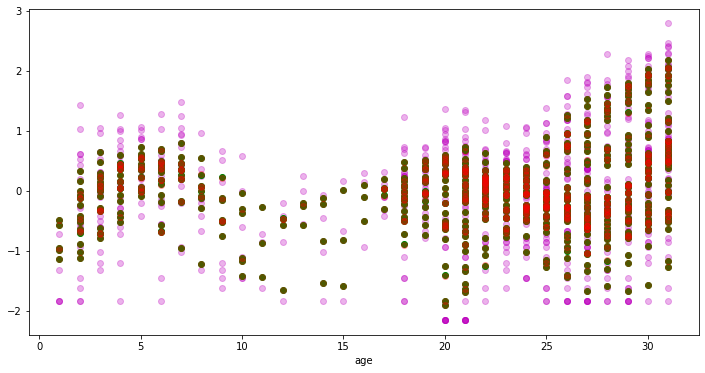

In [87]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
ax.scatter(age_data, stacked_yhat, color="green", linewidth=1)
ax.scatter(age_data, gp_stacked_yhat, color="r", linewidth=1, alpha=0.3)
#ax.scatter(age_data, stacked_yhat, color="green", linewidth=1, alpha=0.5)